In [1]:
using JuMP, AmplNLWriter, Gurobi
using Plots
using Random
using Statistics, LinearAlgebra
include("utils.jl")
Random.seed!(123);

n_samples = 200
n_features = 2

# #Generate the points
# y = zeros(n_samples)

# r = rand(n_samples)
# theta = rand(n_samples)*2*pi
# x = hcat(r.*cos.(theta), r.*sin.(theta))

# x[1:Int(n_samples/2),1] = x[1:Int(n_samples/2),1] .+ 2
# x[1:Int(n_samples/2),2] = x[1:Int(n_samples/2),2] .+ 1
# y[1:Int(n_samples/2)] = ones(Int(n_samples/2))

# x[Int(n_samples/2)+1:end,1] = x[Int(n_samples/2)+1:end,1] .+ 1
# x[Int(n_samples/2)+1:end,2] = x[Int(n_samples/2)+1:end,2] .+ 3
# # x[n_samples,1] = 1.25
# # x[n_samples,2] = 1
# y[Int(n_samples/2)+1:end] = -ones(Int(n_samples/2));

x, y = get_donut(n_samples=n_samples) # , R_inner=5, R_outer=15)
#x, y = get_clouds(n_samples=n_samples)

([2.88702 5.47581; -4.81633 5.14585; … ; -2.69634 10.3014; 9.47861 2.57994], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

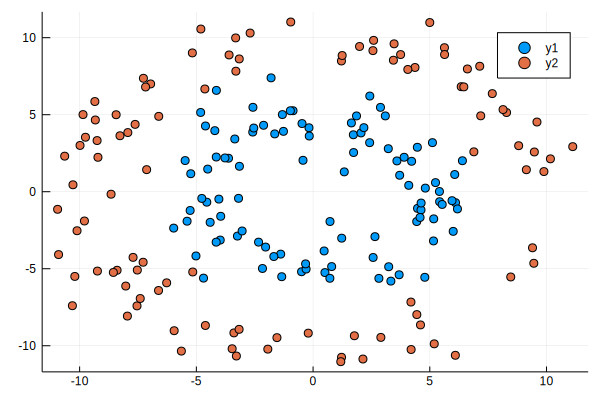

In [2]:
plot_classes(x,y)

In [3]:

# Kernel functions

# Linear Kernel
function linear(x1, x2; c=nothing)
    if c == nothing
        c = 0
    end
    if ndims(x1) == 1 && ndims(x2) == 1
        result = x1'*x2 .+ c
    elseif ndims(x1) > 1 && ndims(x2) == 1
        result = x1*x2 .+ c
    elseif ndims(x1) == 1 && ndims(x2) > 1
        result = x2*x1 .+ c
    else
        throw("linear kernel unimplemented for the given dimensions")
    end
    return result
end


# Gaussian Kernel
function rbf(x1, x2; gamma=nothing)
    if gamma == nothing
        gamma = 1.0 / size(x1)[end]
        #println("gamma=$gamma")
    end
    if ndims(x1) == 1 && ndims(x2) == 1
        result = exp(-gamma * norm(x1 - x2).^2)
    elseif ndims(x1) > 1 && ndims(x2) == 1
        result = exp.(-gamma * mapslices(norm, x1 - repeat(x2',size(x1,1)), dims=2).^2)
    elseif ndims(x1) == 1 && ndims(x2) > 1
        result = exp.(-gamma * mapslices(norm, repeat(x1',size(x2,1)) - x2, dims=2).^2)
#     elseif ndims(x1) > 1 && ndims(x2) > 1 && size(x1) == size(x2)
#         result = exp.(-gamma .* mapslices(norm, x1 .- x2, dims=2).^2)
    else
        throw("unimplemented")
    end
    return result
end

# Sigmoid Kernel
function sigmoid(x1, x2; gamma=0.05, c=1)
    if ndims(x1) == 1 && ndims(x2) == 1
        result = tanh(gamma * x1'*x2 + c)
    elseif ndims(x1) > 1 && ndims(x2) == 1
        result = tanh.(gamma .* x1*x2 .+ c)
    elseif ndims(x1) == 1 && ndims(x2) > 1
        result = tanh.(gamma .* x2*x1 .+ c)
    else
        throw("unimplemented")
    end
    return result
end


sigmoid (generic function with 1 method)

In [4]:

function solve_dual_svm(x,y,C; kernel="linear", c=nothing, gamma=nothing)
    N, N_dims = size(x)

    # Optimization model
    #model = Model(solver=AmplNLSolver("couenne", [""]));
    model = Model(solver=AmplNLSolver("ipopt", [""]));
    #model = Model(solver=GurobiSolver(TimeLimit=400))

    # Variables
    @variable(model, 0.0 <= α[1:N] <= C)

    K = zeros(N,N);
    for i=1:N
        for j=1:N
            # Kernel function
            if kernel == "linear"
                K[i,j] = linear(x[i,:], x[j,:], c=c)
            elseif kernel == "rbf"
                K[i,j] = rbf(x[i,:], x[j,:], gamma=gamma)
            elseif kernel == "sigmoid"
                K[i,j] = sigmoid(x[i,:], x[j,:], gamma=gamma, c=c)
            else
                throw("unimplemented")
            end
        end
    end

    # Objective
    @NLobjective(model, Max, sum(α[i] for i=1:N) - 0.5*sum(α[i]*α[j]*y[i]*y[j]*K[i,j] for i=1:N, j=1:N));

    # Constraints
    @constraint(model, con, sum(α[i]*y[i] for i=1:N) == 0)

    # Solve
    println()
    status = solve(model)
    solvetime = getsolvetime(model)
    obj_value = getobjectivevalue(model);
    println("Solve time: ", solvetime)
    println("Objective=", obj_value);

    # Recover variable values

    α_opt = getvalue(α)

    w = sum(α_opt[i]*y[i]*x[i,:] for i=1:N if α_opt[i] > 0)
                
    if kernel == "linear"
        b = y[α_opt .> 0] - sum(α_opt[i]*y[i]*linear(x[i,:],x[α_opt .> 0,:],c=c) for i=1:N if α_opt[i] > 0)
    elseif kernel == "rbf"
        b = y[α_opt .> 0] - sum(α_opt[i]*y[i]*rbf(x[i,:],x[α_opt .> 0,:],gamma=gamma) for i=1:N if α_opt[i] > 0)
    elseif kernel == "sigmoid"
        b = y[α_opt .> 0] - sum(α_opt[i]*y[i]*sigmoid(x[i,:],x[α_opt .> 0,:],gamma=gamma,c=c) for i=1:N if α_opt[i] > 0)
    end 
    b = mean(b)
    println("w=$w")
    println("b=$b")
    return w, b, α_opt
end


solve_dual_svm (generic function with 1 method)

In [5]:
C = 1.0
kernel = "rbf"
gamma = nothing
c = nothing
println("C=$C")
w_opt, b_opt, α_opt = solve_dual_svm(x,y,C; kernel=kernel, gamma=gamma, c=c)

C=1.0

Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      200
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20100

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        

([-44.0377, -2.34521], 0.21632136789258477, [0.0, 1.0, 0.557664, 0.0, 0.485666, 1.48097e-8, 2.34793e-8, 1.92576e-9, 7.7871e-10, 1.00995e-8  …  0.699859, 0.297607, 1.44205e-8, 0.61411, 0.665196, 0.538944, 7.85838e-9, 3.21097e-7, 0.551506, 6.52138e-9])

In [6]:
# Predict
N = size(x,1)
y_pred = zeros(N)

K = zeros(N,N);
for i=1:N
    for k=1:N
        # Kernel function
        if kernel == "linear"
            K[i,k] = linear(x[i,:], x[k,:], c=c)
        elseif kernel == "rbf"
            K[i,k] = rbf(x[i,:], x[k,:], gamma=gamma)
        elseif kernel == "sigmoid"
            K[i,k] = sigmoid(x[i,:], x[k,:], gamma=gamma, c=c)
        else
            throw("unimplemented")
        end
    end
end

for i=1:N
    y_pred[i] = sum(α_opt[k]*y[k]*K[i,k] for k=1:N if α_opt[k] > 1e-7) + b_opt
end
            
y_pred[y_pred .>= 0] = ones(sum(y_pred .>= 0))
y_pred[y_pred .< 0] = -1.0 .* ones(sum(y_pred .< 0));

In [7]:
resolution = 100

N, N_dims = size(x)

x_range = range(minimum(x[:,1]), stop=maximum(x[:,1]), length=resolution)
y_range = range(minimum(x[:,2]), stop=maximum(x[:,2]), length=resolution)

grid = zeros(resolution, resolution)
for (i,xr) in enumerate(x_range)
    # Print value of i for the user to see the progress
    if i % 10 == 0
        println("i=$i")
    end
    for (j,yr) in enumerate(y_range)
        x_new = [xr; yr]
        if kernel == "linear"
            grid[i,j] = sum(α_opt[k]*y[k]*linear(x[k,:], x_new, c=c) for k=1:N if α_opt[k] > 1e-7) + b_opt
        elseif kernel == "rbf"
            grid[i,j] = sum(α_opt[k]*y[k]*rbf(x[k,:], x_new, gamma=gamma) for k=1:N if α_opt[k] > 1e-7) + b_opt
        elseif kernel == "sigmoid"
            grid[i,j] = sum(α_opt[k]*y[k]*linear(x[k,:], x_new, gamma=gamma, c=c) for k=1:N if α_opt[k] > 1e-7) + b_opt
        else
            throw("unimplemented")
        end
        #grid[i,j] = sum(α_opt[k]*y[k]*K[k] for k=1:N if α_opt[k] > 1e-7) + b_opt
    end
end
grid = grid';

i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
i=100


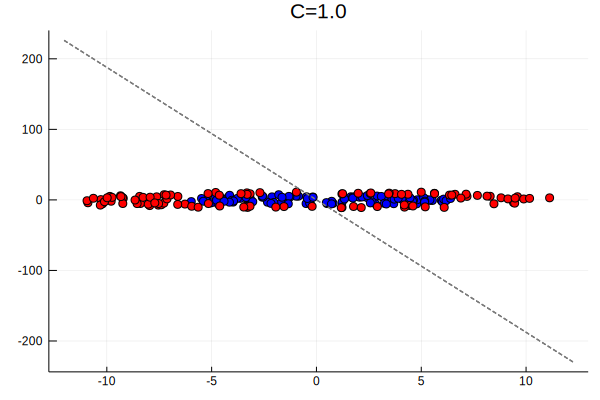

In [8]:
# Retrieve equation for the optimal separation line
min_x = minimum(x[:,1])
max_x = maximum(x[:,1])
min_y = minimum(x[:,2])
max_y = maximum(x[:,2])
xx = range(min_x-abs(min_x)*0.1,stop=max_x+abs(max_x)*0.1,length=1000)
a = - w_opt[1] / w_opt[2]
y_line = a.*xx .+ (-b_opt / w_opt[2])

# Equations for the margins
y_margin1 = a.*xx .+ ((1 - b_opt) / w_opt[2])
y_margin2 = a.*xx .+ ((-1 - b_opt) / w_opt[2])

plt = scatter(x[y .== -1,1], x[y .== -1,2], color=:blue, leg=false, title="C=$C")
plt = scatter!(x[y .== 1,1], x[y .== 1,2], color=:red, leg=false)
plt = plot!(xx, y_line, linestyle=:dash, color=:black, leg=false)
plt = plot!(xx, y_margin1, linestyle=:dash, color=:gray, leg=false)
plt = plot!(xx, y_margin2, linestyle=:dash, color=:gray, leg=false)

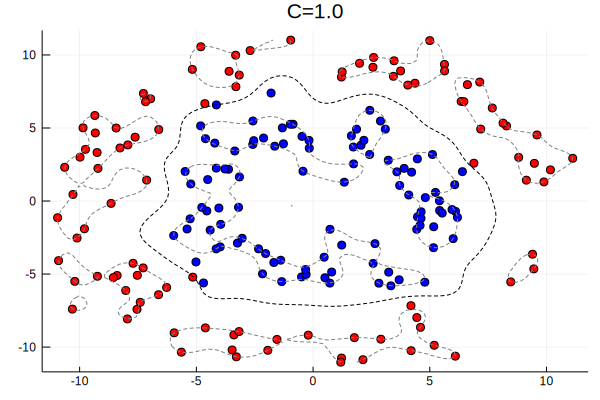

In [9]:
# Plot decision contours using grid and
# make a scatter plot of training data
#plt = contour(x_range, y_range, grid, levels=[-1,0,1], linestyles=[:dash,:dash,:dash], color=:gray)
plt = scatter(x[y .== -1,1], x[y .== -1,2], color=:blue, leg=false, title="C=$C")
plt = scatter!(x[y .== 1,1], x[y .== 1,2], color=:red, leg=false)
plt = contour!(x_range, y_range, grid, levels=[-1,1], linestyles=[:dash,:dash], color=:gray)
plt = contour!(x_range, y_range, grid, levels=[0], linestyles=[:dash], color=:black)

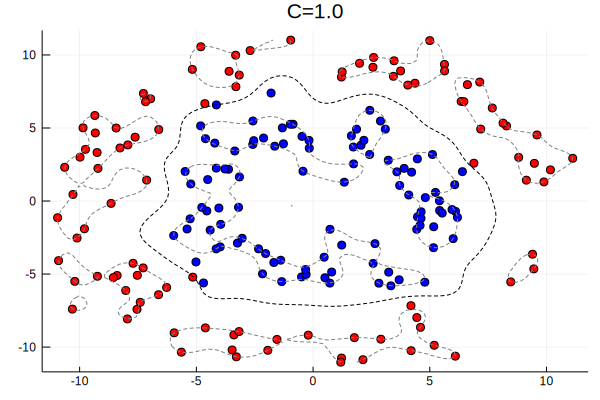

In [10]:
# Plot decision contours using grid and
# make a scatter plot of training data
plt = scatter(x[y_pred .== -1,1], x[y_pred .== -1,2], color=:blue, leg=false, title="C=$C")
plt = scatter!(x[y_pred .== 1,1], x[y_pred .== 1,2], color=:red, leg=false)
plt = contour!(x_range, y_range, grid, levels=[-1,1], linestyles=[:dash,:dash], color=:gray)
plt = contour!(x_range, y_range, grid, levels=[0], linestyles=[:dash], color=:black)